# **Research Question:**
Can time series analysis with machine learning models identify recurring seasonal patterns and trends in sales data across different FMCG product categories and forecast future units sold?

# **Importing Libraries and Datasets**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
breakfast = pd.ExcelFile('C:\\Users\\malak\\Desktop\\Breakfast_at_the_Frat.xlsx')

In [3]:
# reading each sheet inside the excel file
stores=breakfast.parse(sheet_name=1,header=1,usecols=range(9))
products=breakfast.parse(sheet_name=2,header=1, usecols=range(6))
transactions=breakfast.parse(sheet_name=3,header=1,usecols=range(12))

In [4]:
#Combining stores and products dataframes with transaction dataframe
stores.rename(columns={'STORE_ID': 'STORE_NUM'}, inplace=True) # so the merge will happen successfully
combined_data = transactions.merge(products, on='UPC').merge(stores, how='outer', on='STORE_NUM')
combined_data.shape

(538643, 25)

In [5]:
# Sort the DataFrame by 'WEEK_END_DATE'
combined_data.sort_values(by='WEEK_END_DATE', inplace=True)

<h1 style="color:black; font-size:30px;"><strong>Length of Time Period</strong></h1>

In [6]:
combined_data.WEEK_END_DATE.describe()
#156 weeks

count                           538643
mean     2010-07-17 19:20:53.115699968
min                2009-01-14 00:00:00
25%                2009-10-28 00:00:00
50%                2010-07-21 00:00:00
75%                2011-04-13 00:00:00
max                2012-01-04 00:00:00
Name: WEEK_END_DATE, dtype: object

# **From Text To Date**

In [7]:
combined_data.WEEK_END_DATE = pd.to_datetime(combined_data.WEEK_END_DATE)

<h1 style="color:black; font-size:30px;"><strong>Setting The Index</strong></h1>

In [8]:
combined_data.set_index("WEEK_END_DATE", inplace = True)

In [9]:
combined_data.head()

,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,...,SUB_CATEGORY,PRODUCT_SIZE,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
WEEK_END_DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,...,PRETZELS,15 OZ,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
2009-01-14,21485,3000006610,30,24,23,60.00,2.00,2.59,0,1,...,KIDS CEREAL,14 OZ,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472.237179
2009-01-14,21485,3700019521,2,2,2,5.00,2.50,3.49,0,0,...,MOUTHWASH/RINSES AND SPRAYS,4.2 OZ,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472.237179
2009-01-14,21485,3700044982,3,3,3,13.50,4.50,4.50,0,0,...,MOUTHWASHES (ANTISEPTIC),1 LT,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472.237179
2009-01-14,21485,3800031829,7,7,7,20.16,2.88,2.88,0,0,...,ALL FAMILY CEREAL,18 OZ,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472.237179


# **Setting The Desired Frequency**

In [10]:
#setting the desired frequency is already done. The time period provided in the "dh Transaction Data" is referred to as "week_end_date."
# This indicates that the data is organized based on weekly intervals, and the "week_end_date" column represents the ending date of each week for which the transactions are recorded.
#Therefore, the time period in this dataset is weekly.

<h1 style="color:black; font-size:30px;"><strong>Handling Missing Values</strong></h1>
*not needed anymore as these columns will be dropped

In [11]:
combined_data.isna().sum()

STORE_NUM                       0
UPC                             0
UNITS                           0
VISITS                          0
HHS                             0
SPEND                           0
PRICE                          23
BASE_PRICE                    185
FEATURE                         0
DISPLAY                         0
TPR_ONLY                        0
DESCRIPTION                     0
MANUFACTURER                    0
CATEGORY                        0
SUB_CATEGORY                    0
PRODUCT_SIZE                    0
STORE_NAME                      0
ADDRESS_CITY_NAME               0
ADDRESS_STATE_PROV_CODE         0
MSA_CODE                        0
SEG_VALUE_NAME                  0
PARKING_SPACE_QTY          366061
SALES_AREA_SIZE_NUM             0
AVG_WEEKLY_BASKETS              0
dtype: int64

In [12]:
# Step 1: Forward-fill missing prices within each group of transactions with the same UPC
combined_data['PRICE'] = combined_data.groupby('UPC')['PRICE'].ffill()

# Step 2: Backward-fill any remaining missing prices
combined_data['PRICE'] = combined_data.groupby('UPC')['PRICE'].bfill()

# Verify if there are still missing prices
missing_prices = combined_data['PRICE'].isnull().sum()
print("Number of missing prices after filling:", missing_prices)

Number of missing prices after filling: 0


In [13]:
# Step 1: Forward-fill missing base prices within each group of transactions with the same UPC
combined_data['BASE_PRICE'] = combined_data.groupby('UPC')['BASE_PRICE'].ffill()

# Step 2: Backward-fill any remaining missing base prices
combined_data['BASE_PRICE'] = combined_data.groupby('UPC')['BASE_PRICE'].bfill()

# Verify if there are still missing base prices
missing_Bprices = combined_data['BASE_PRICE'].isnull().sum()
print("Number of missing base prices after filling:", missing_Bprices)

Number of missing base prices after filling: 0


In [14]:
# Step 1: Group by "SEG_VALUE_NAME" and calculate the average parking space quantity
avg_parking_space_qty = combined_data.groupby('SEG_VALUE_NAME')['PARKING_SPACE_QTY'].mean()

# Step 2: Fill missing values in the "PARKING_SPACE_QTY" column with the corresponding averages
combined_data['PARKING_SPACE_QTY'] = (
    combined_data['PARKING_SPACE_QTY'].fillna(
        combined_data['SEG_VALUE_NAME'].map(avg_parking_space_qty)
    )
)

# Verify if there are still missing values in the "PARKING_SPACE_QTY" column
missing_parking_space_qty = combined_data['PARKING_SPACE_QTY'].isnull().sum()
print("Number of missing parking space quantities after filling:", missing_parking_space_qty)

Number of missing parking space quantities after filling: 0


In [15]:
combined_data.isna().sum()

STORE_NUM                  0
UPC                        0
UNITS                      0
VISITS                     0
HHS                        0
SPEND                      0
PRICE                      0
BASE_PRICE                 0
FEATURE                    0
DISPLAY                    0
TPR_ONLY                   0
DESCRIPTION                0
MANUFACTURER               0
CATEGORY                   0
SUB_CATEGORY               0
PRODUCT_SIZE               0
STORE_NAME                 0
ADDRESS_CITY_NAME          0
ADDRESS_STATE_PROV_CODE    0
MSA_CODE                   0
SEG_VALUE_NAME             0
PARKING_SPACE_QTY          0
SALES_AREA_SIZE_NUM        0
AVG_WEEKLY_BASKETS         0
dtype: int64

# **Simplifying The Dataset**

In [16]:
combined_data_copy= combined_data.copy()

In [17]:
# Filter the DataFrame to include only the bag snacks category
combined_data_copy = combined_data_copy[combined_data_copy['CATEGORY'] == 'BAG SNACKS']


columns_to_drop = [
    'STORE_NUM', 'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
    'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'DISPLAY', 'FEATURE',
    'TPR_ONLY', 'HHS', 'VISITS', 'MANUFACTURER', 'AVG_WEEKLY_BASKETS', 'STORE_NAME','ADDRESS_CITY_NAME',
    'PRODUCT_SIZE', 'UPC','SPEND','PRICE','BASE_PRICE','DESCRIPTION', 'CATEGORY','SUB_CATEGORY'
]

# Drop the specified columns from the DataFrame
combined_data_copy = combined_data_copy.drop(columns=columns_to_drop)

combined_data_copy.sort_values(by='WEEK_END_DATE', inplace=True)

print(combined_data_copy.head())

               UNITS
WEEK_END_DATE       
2009-01-14        13
2009-01-14        67
2009-01-14        15
2009-01-14        14
2009-01-14         3


# **Exploratory Data Analysis (EDA)**

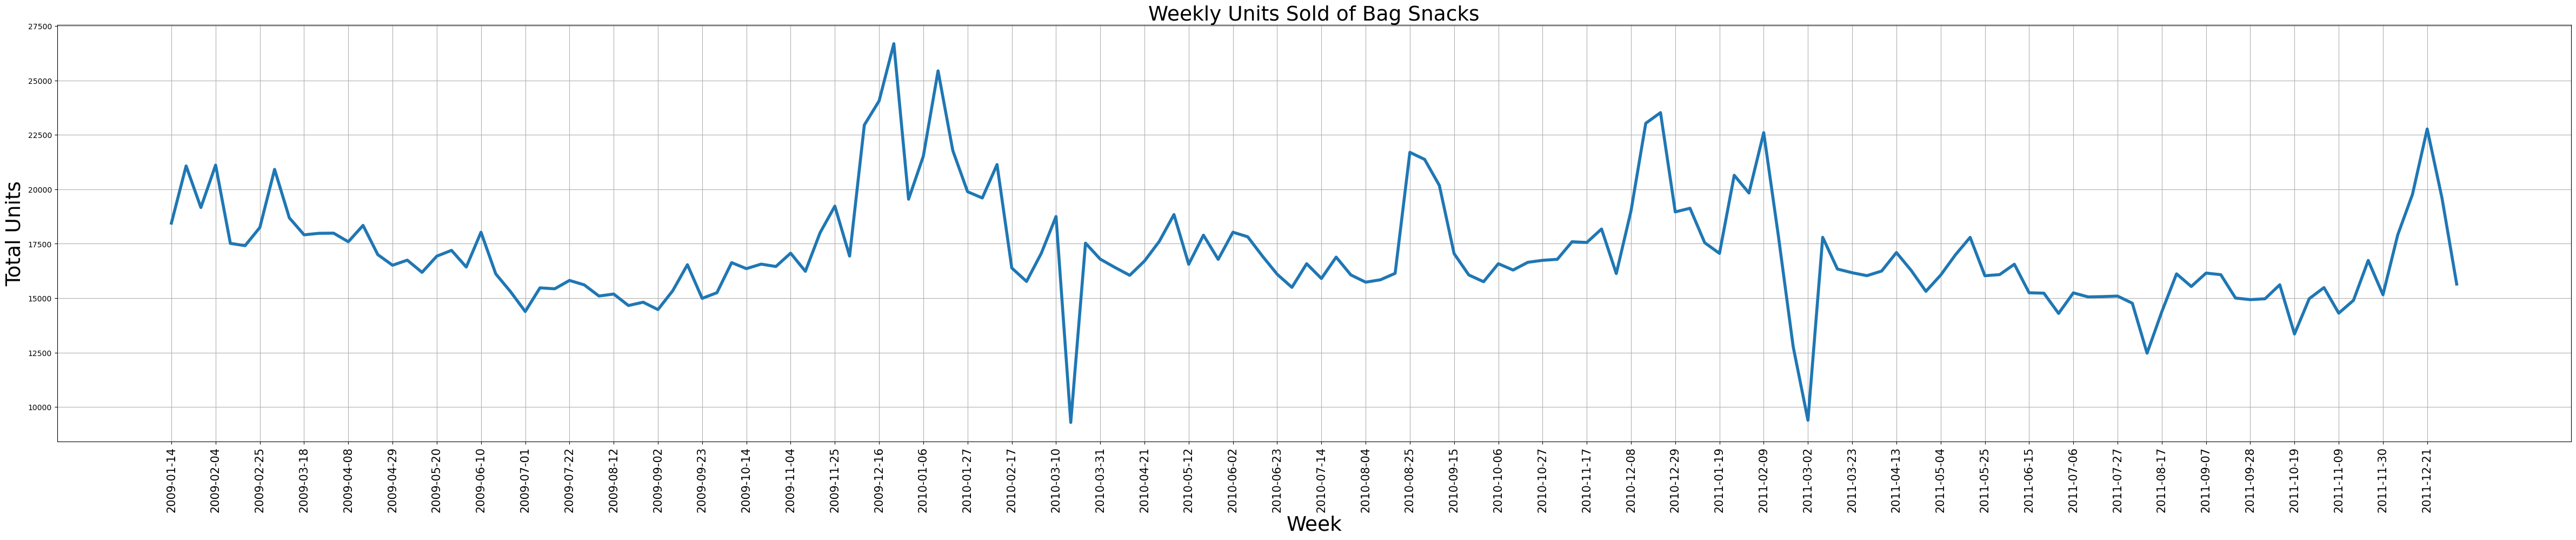

In [18]:
# Group data by week and sum units sold for each week
weekly_units_sold = combined_data_copy.groupby('WEEK_END_DATE')['UNITS'].sum()

# Convert the Series to a DataFrame
weekly_units_sold_df = weekly_units_sold.to_frame(name='UNITS')
# Plot the time series data
plt.figure(figsize=(60, 10))
plt.plot(weekly_units_sold_df, linewidth=4)

# Set x-axis tick labels for every week
plt.xticks(weekly_units_sold_df.index[::3], rotation=90, fontsize=15)

plt.title('Weekly Units Sold of Bag Snacks', fontsize=27)
plt.xlabel('Week', fontsize=27)
plt.ylabel('Total Units', fontsize=27)
plt.grid(True)

In [19]:
weekly_units_sold_df

,UNITS
WEEK_END_DATE,
2009-01-14,18448
2009-01-21,21075
2009-01-28,19164
2009-02-04,21113
2009-02-11,17517
...,...
2011-12-07,17903
2011-12-14,19765
2011-12-21,22774


<h1 style="color:black; font-size:30px;"><strong>Yearly Patterns</strong></h1>
 Group the data by year and overlay the yearly plots to directly compare the same weeks across different years.

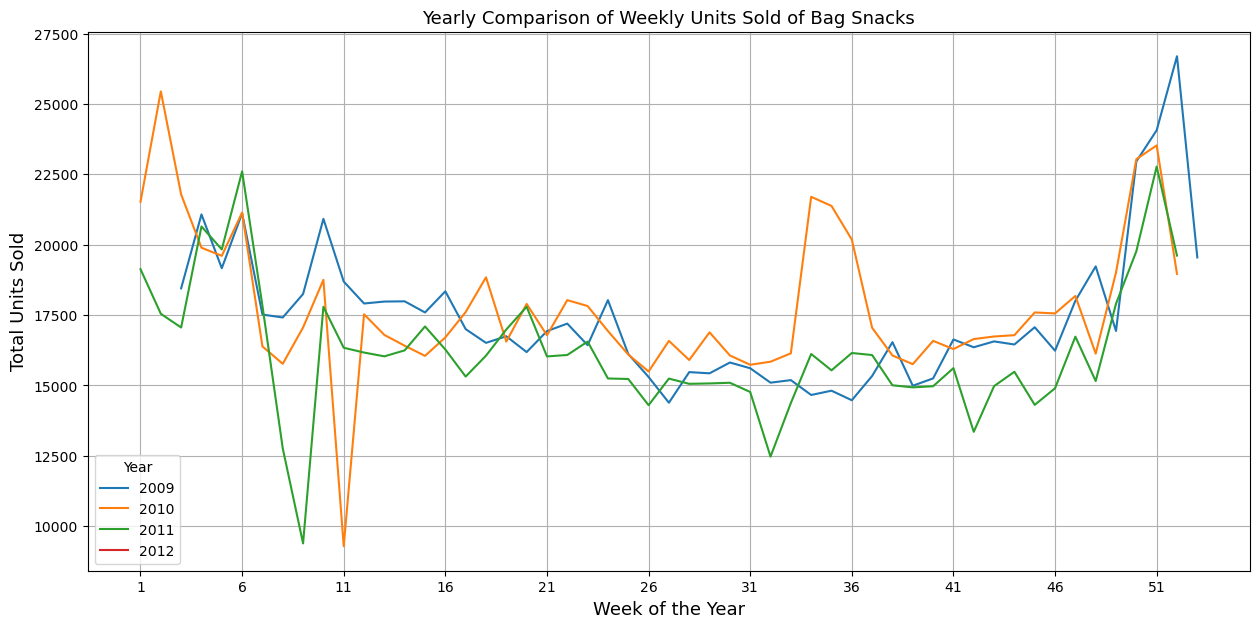

In [20]:
# Create a column that indicates the week number
weekly_units_sold_df['week_of_year'] = weekly_units_sold_df.index.isocalendar().week

# Plot the time series data of each year on the same plot for comparison
plt.figure(figsize=(15, 7))

# Extract years from the index for looping
years = weekly_units_sold_df.index.year.unique()

for year in years:
    # Extract the subset of data for the specific year
    yearly_data = weekly_units_sold_df[weekly_units_sold_df.index.year == year]
    plt.plot(yearly_data['week_of_year'], yearly_data['UNITS'], label=year)

# Set x-axis tick labels for all weeks of the year
weeks_in_year = range(1, 53,5)  # Assuming weeks are numbered from 1 to 52
plt.xticks(weeks_in_year)

plt.title('Yearly Comparison of Weekly Units Sold of Bag Snacks', fontsize=13)
plt.xlabel('Week of the Year', fontsize=13)
plt.ylabel('Total Units Sold',fontsize=13)
plt.legend(title='Year')
plt.grid(True)
plt.show()

<h1 style="color:black; font-size:30px;"><strong>Seasonal Decomposition</strong></h1>

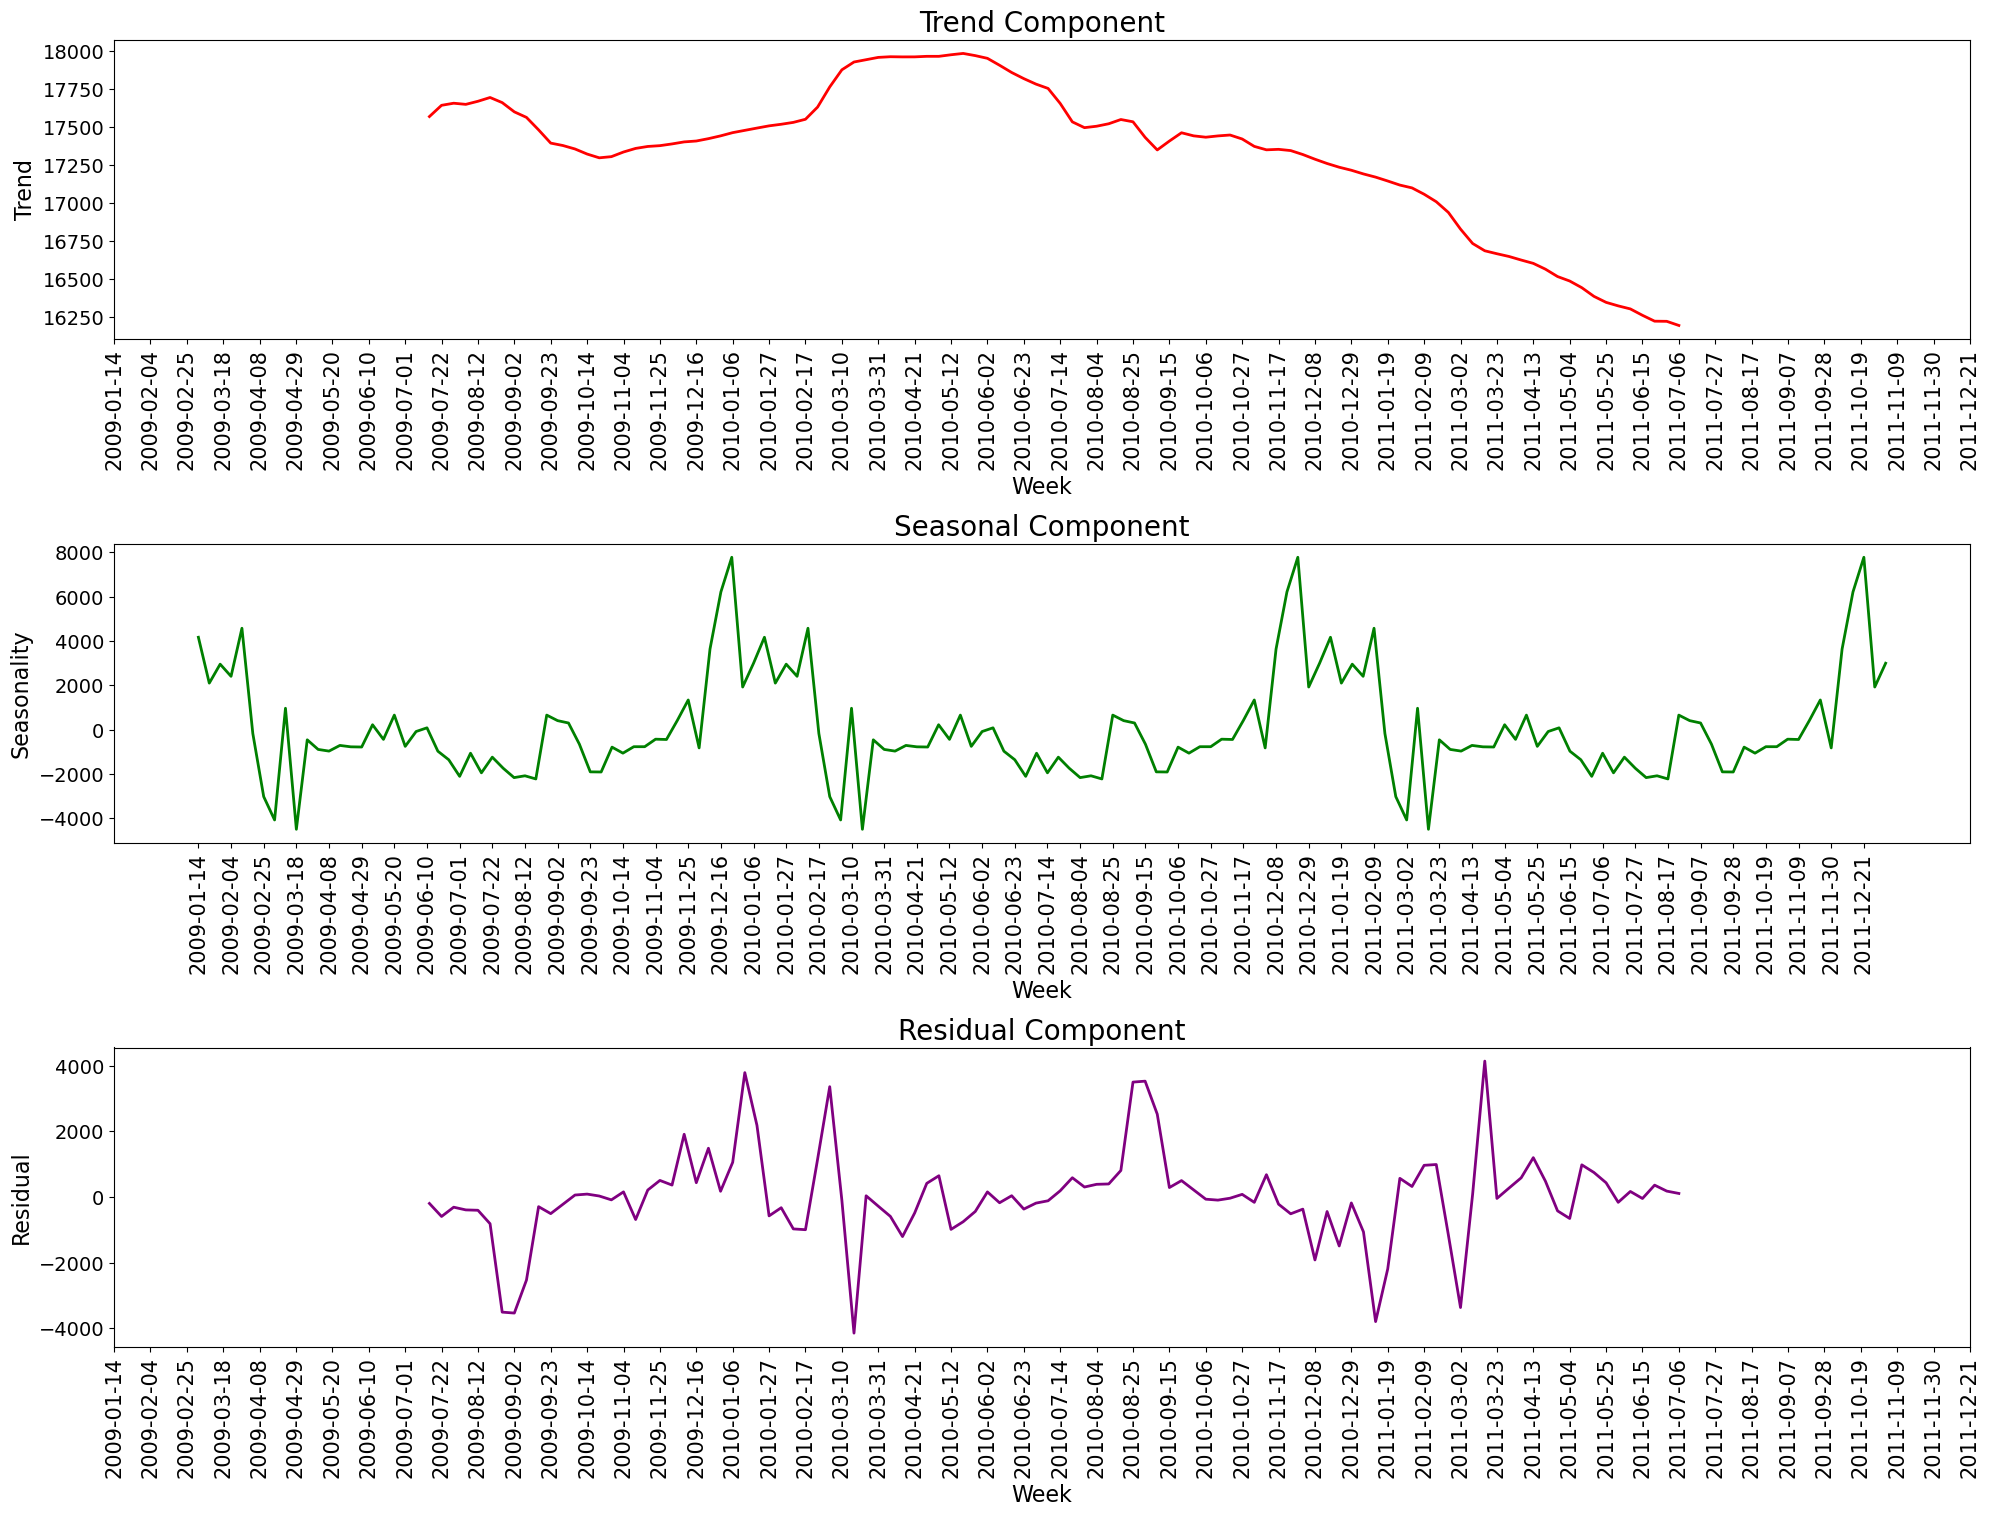

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20, 20)) 

decomposition = seasonal_decompose(weekly_units_sold, model='additive', period=52)  # Assuming weekly data with a yearly cycle

# Plotting the trend component
plt.subplot(4, 1, 2)  # 4 rows, 1 column, 2nd subplot
plt.plot(decomposition.trend, linewidth=2, color='r')
plt.title('Trend Component', fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Trend', fontsize=16)
plt.xticks(weekly_units_sold.index[::3], rotation=90, fontsize=15)
plt.yticks(fontsize=14)

# Plotting the seasonal component
plt.subplot(4, 1, 3)  # 4 rows, 1 column, 3rd subplot
plt.plot(decomposition.seasonal, linewidth=2, color='g')
plt.title('Seasonal Component', fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Seasonality', fontsize=16)
plt.xticks(weekly_units_sold.index[::3], rotation=90, fontsize=15)
plt.yticks(fontsize=14)

# Plotting the residual component
plt.subplot(4, 1, 4)  # 4 rows, 1 column, 4th subplot
plt.plot(decomposition.resid, linewidth=2, color='purple')
plt.title('Residual Component', fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Residual', fontsize=16)
plt.xticks(weekly_units_sold.index[::3], rotation=90, fontsize=15)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [22]:
# Calculate the seasonal amplitude
seasonal_amplitude = (decomposition.seasonal.max() - decomposition.seasonal.min()) / 2
print("Seasonal Amplitude: ", seasonal_amplitude)

# Calculate average sales
average_sales = weekly_units_sold.mean()

# Calculate amplitude as a percentage of average sales
amplitude_percentage = (seasonal_amplitude / average_sales) * 100
print("Amplitude as a percentage of average sales: {:.2f}%".format(amplitude_percentage))

Seasonal Amplitude:  6136.3629807692305
Amplitude as a percentage of average sales: 35.82%


<h1 style="color:black; font-size:30px;"><strong>Stationarity Check</strong></h1>

In [23]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(weekly_units_sold_df['UNITS'])

# Format the output to show up to 3 decimal places
adf_test_output = {
    'Test Statistic': round(adf_test[0], 3),
    'p-value': adf_test[1],
    'Critical Value (1%)': round(adf_test[4]['1%'], 3),
    'Critical Value (5%)': round(adf_test[4]['5%'], 3),
    'Critical Value (10%)': round(adf_test[4]['10%'], 3)
}

# Print each item on a separate line
for key, value in adf_test_output.items():
    print(f"{key}: {value}")

Test Statistic: -5.969
p-value: 1.9517067354807762e-07
Critical Value (1%): -3.473
Critical Value (5%): -2.88
Critical Value (10%): -2.577


# **Autocorrelation Analysis**

In [24]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

# ***1.ACF***

<Figure size 1500x600 with 0 Axes>

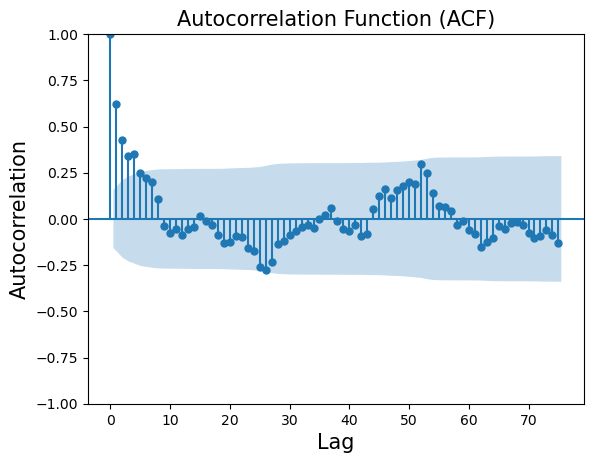

In [25]:
# Set figure size
plt.figure(figsize=(15, 6))

# Plot the autocorrelation function (ACF) with lags up to 75
acf_plot = plot_acf(weekly_units_sold, lags=75)

# Set plot title and labels
plt.title('Autocorrelation Function (ACF)', fontsize=15)
plt.xlabel('Lag', fontsize=15)
plt.ylabel('Autocorrelation', fontsize=15)

# Show the plot
plt.show()

# ***2.PACF***

<Figure size 1500x600 with 0 Axes>

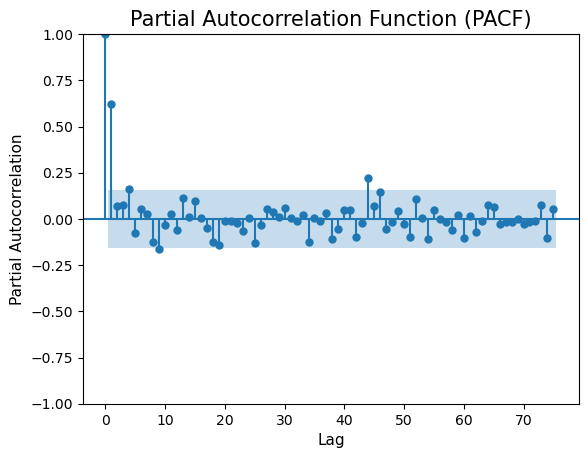

In [26]:
# Set figure size
plt.figure(figsize=(15, 6))

# Plot the partial autocorrelation function (PACF) with lags up to 75
pacf_plot = plot_pacf(weekly_units_sold, lags=75)

# Set plot title and labels
plt.title('Partial Autocorrelation Function (PACF)', fontsize=15)
plt.xlabel('Lag', fontsize=11)
plt.ylabel('Partial Autocorrelation', fontsize=11)

# Show the plot
plt.show()

# ***Splitting Dataset***

In [27]:
split_point = int(len(weekly_units_sold) * 0.8)
train, test = weekly_units_sold[:split_point], weekly_units_sold[split_point:]
train.index = pd.DatetimeIndex(train.index, freq='W-WED')
test.index = pd.DatetimeIndex(test.index, freq='W-WED')

In [28]:
train

WEEK_END_DATE
2009-01-14    18448
2009-01-21    21075
2009-01-28    19164
2009-02-04    21113
2009-02-11    17517
              ...  
2011-04-27    15314
2011-05-04    16057
2011-05-11    16988
2011-05-18    17794
2011-05-25    16030
Freq: W-WED, Name: UNITS, Length: 124, dtype: int64

In [29]:
test

WEEK_END_DATE
2011-06-01    16081
2011-06-08    16558
2011-06-15    15247
2011-06-22    15229
2011-06-29    14298
2011-07-06    15243
2011-07-13    15057
2011-07-20    15071
2011-07-27    15095
2011-08-03    14767
2011-08-10    12471
2011-08-17    14375
2011-08-24    16117
2011-08-31    15536
2011-09-07    16152
2011-09-14    16079
2011-09-21    15005
2011-09-28    14932
2011-10-05    14971
2011-10-12    15614
2011-10-19    13352
2011-10-26    14976
2011-11-02    15485
2011-11-09    14309
2011-11-16    14900
2011-11-23    16732
2011-11-30    15156
2011-12-07    17903
2011-12-14    19765
2011-12-21    22774
2011-12-28    19613
2012-01-04    15648
Freq: W-WED, Name: UNITS, dtype: int64

<h1 style="color:black; font-size:30px;"><strong>Modelling</strong></h1>

In [30]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:black; font-size:30px;"><strong>AutoARIMA</strong></h1>

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2267.259, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2779.215, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2638.473, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2264.951, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.93 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2265.232, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2254.708, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2252.824, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2267.643, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2251.635, Time=0.05 s

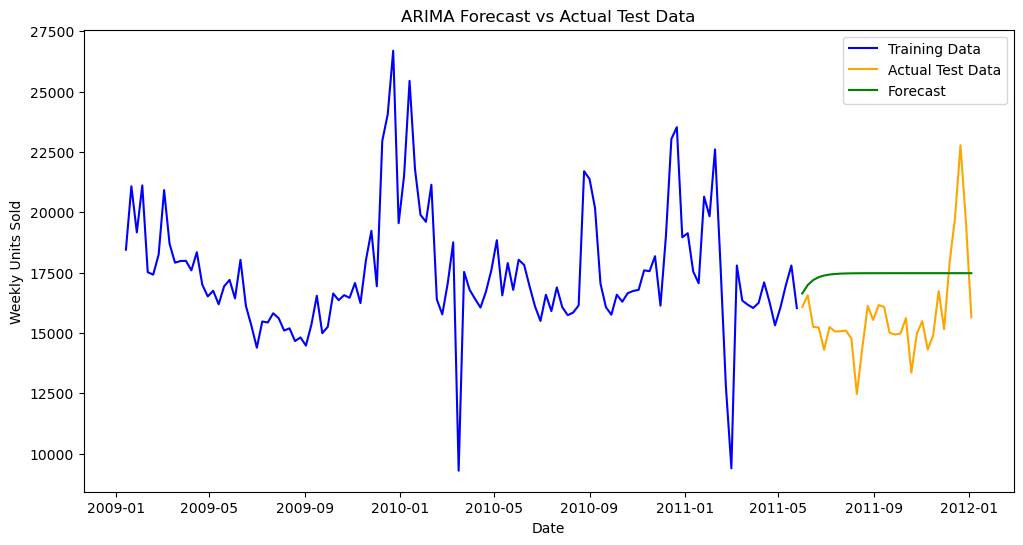

In [31]:
from pmdarima import auto_arima
best_model = auto_arima(train, start_p=1, start_q=1,
                        max_p=5, max_q=5, m=0,
                        seasonal=False,  # Change based on your data
                        d=None,  # Let auto_arima determine the best 'd'
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
forecast = best_model.predict(n_periods=len(test))

forecast_index = test.index

# Plot the training data, actual test data, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')

plt.title('ARIMA Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Weekly Units Sold')
plt.legend()
plt.show()

<h1 style="color:black; font-size:30px;"><strong>Evaluation of AutoARIMA</strong></h1>

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(test, forecast, squared=False)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test, forecast)

# Print the results
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')

Root Mean Squared Error: 2527.938003029807
Mean Absolute Error: 2280.800589030818
Mean Absolute Percentage Error: 0.14838085769075865


In [33]:
# Calculate the average of the actual test data
average_sales = test.mean()

# Calculate RMSE and MAE as a percentage of the average sales
rmse_percentage = (rmse / average_sales) * 100
mae_percentage = (mae / average_sales) * 100

# Now, you can print these percentages to assess the error magnitude relative to the data scale

print(f'RMSE as a percentage of average sales: {rmse_percentage}%')
print(f'MAE as a percentage of average sales: {mae_percentage}%')

RMSE as a percentage of average sales: 16.0341431796242%
MAE as a percentage of average sales: 14.466606050014011%


<h1 style="color:black; font-size:30px;"><strong>AutoSARIMA</strong></h1>

In [34]:
best_model = auto_arima(train, start_p=0, start_q=0,
                        max_p=3, max_q=3, m=51,
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        seasonal=True,  # Enable seasonal differencing
                        d=1, D=1,  # Assuming one level of differencing is needed
                        trace=True, error_action='ignore',
                        suppress_warnings=True, stepwise=True)

# Print the summary of the best model
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[51]             : AIC=1399.872, Time=0.66 sec
 ARIMA(1,1,0)(1,1,0)[51]             : AIC=1382.046, Time=2.80 sec
 ARIMA(0,1,1)(0,1,1)[51]             : AIC=inf, Time=2.88 sec
 ARIMA(1,1,0)(0,1,0)[51]             : AIC=1390.883, Time=0.52 sec
 ARIMA(1,1,0)(2,1,0)[51]             : AIC=inf, Time=22.81 sec
 ARIMA(1,1,0)(1,1,1)[51]             : AIC=inf, Time=14.98 sec
 ARIMA(1,1,0)(0,1,1)[51]             : AIC=inf, Time=10.33 sec
 ARIMA(1,1,0)(2,1,1)[51]             : AIC=1379.094, Time=12.71 sec
 ARIMA(1,1,0)(2,1,2)[51]             : AIC=1381.094, Time=15.96 sec
 ARIMA(1,1,0)(1,1,2)[51]             : AIC=inf, Time=41.88 sec
 ARIMA(0,1,0)(2,1,1)[51]             : AIC=inf, Time=19.96 sec
 ARIMA(2,1,0)(2,1,1)[51]             : AIC=1376.071, Time=13.76 sec
 ARIMA(2,1,0)(1,1,1)[51]             : AIC=inf, Time=4.19 sec
 ARIMA(2,1,0)(2,1,0)[51]             : AIC=inf, Time=7.77 sec
 ARIMA(2,1,0)(2,1,2)[51]             : AIC=1378.071

<h1 style="color:black; font-size:30px;"><strong>AutoSARIMA Performance on Training & Testing Datasets</strong></h1>

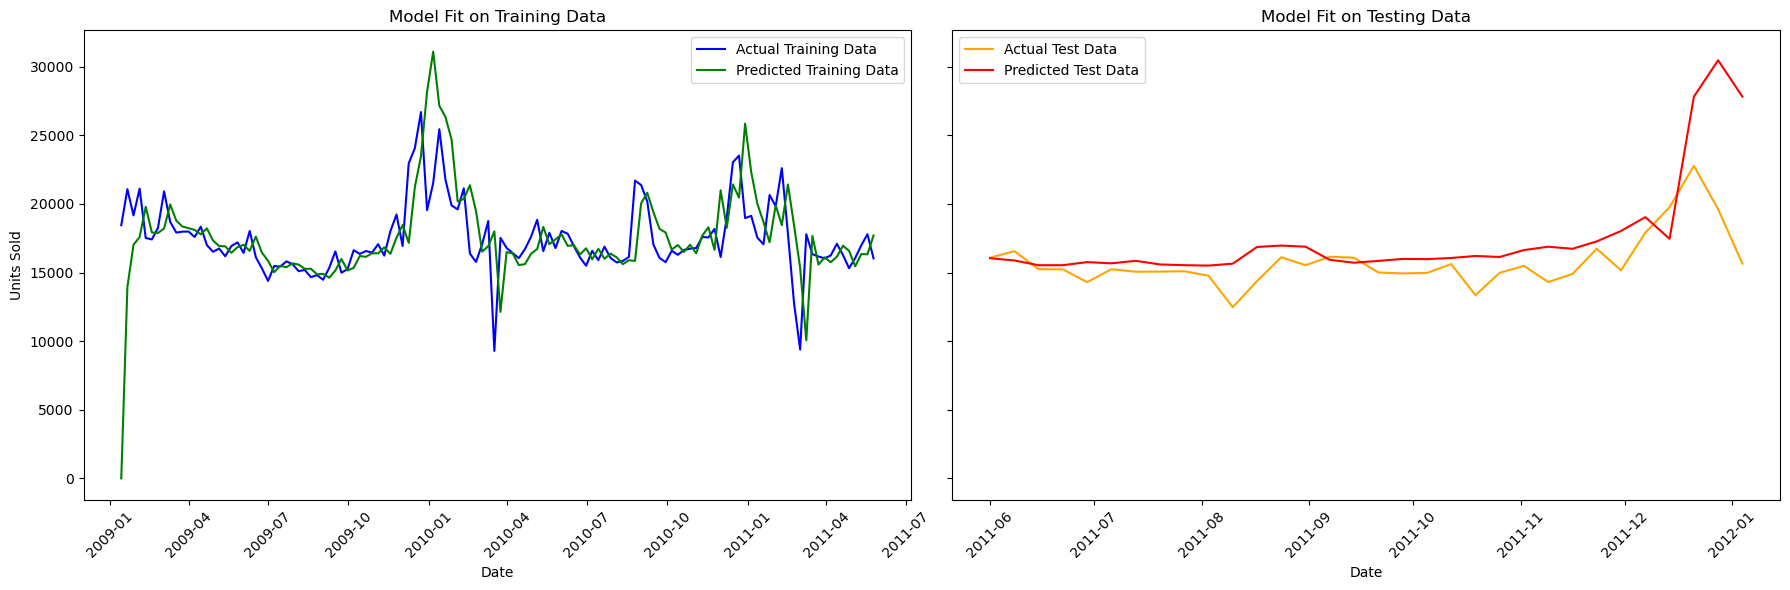

In [35]:
import matplotlib.pyplot as plt

# Prediction on training data
train_pred = best_model.predict_in_sample(start=train.index[0], end=train.index[-1])

# Prediction on testing data
test_pred = best_model.predict(n_periods=len(test))

# Plotting the results on separate subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot for training data
ax[0].plot(train.index, train, label='Actual Training Data', color='blue')
ax[0].plot(train.index, train_pred, label='Predicted Training Data', color='green')
ax[0].set_title('Model Fit on Training Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Units Sold')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot for testing data
ax[1].plot(test.index, test, label='Actual Test Data', color='orange')
ax[1].plot(test.index, test_pred, label='Predicted Test Data', color='red')
ax[1].set_title('Model Fit on Testing Data')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<h1 style="color:black; font-size:30px;"><strong> Evaluation of AutoSARIMA</strong></h1>

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate metrics for the training data
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
train_mae = mean_absolute_error(train, train_pred)
train_mape = calculate_mape(train, train_pred)

# Calculate metrics for the testing data
test_rmse = np.sqrt(mean_squared_error(test, test_pred))
test_mae = mean_absolute_error(test, test_pred)
test_mape = calculate_mape(test, test_pred)


print("Training Data Evaluation Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape}%")


print("\nTesting Data Evaluation Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"MAPE: {test_mape}%")

Training Data Evaluation Metrics:
RMSE: 3134.2636439589373
MAE: 1858.3936038251047
MAPE: 10.730324744968565%

Testing Data Evaluation Metrics:
RMSE: 3325.313507942748
MAE: 1936.9271418634912
MAPE: 11.96329305852156%


<h1 style="color:black; font-size:30px;"><strong> Extra Evaluation of AutoSARIMA</strong></h1>

In [37]:
# Calculate the average of the actual test data
average_sales = test.mean()

# Calculate RMSE and MAE as a percentage of the average sales
rmse_percentage = (test_rmse / average_sales) * 100
mae_percentage = (test_mae / average_sales) * 100

print(f'RMSE as a percentage of average sales: {rmse_percentage}%')
print(f'MAE as a percentage of average sales: {mae_percentage}%')

RMSE as a percentage of average sales: 21.09171698023788%
MAE as a percentage of average sales: 12.285493981227708%


<h1 style="color:black; font-size:30px;"><strong>Holt-Winters Seasonal Method</strong></h1>

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model_add = ExponentialSmoothing(
    train,
    seasonal_periods=51,
    trend='add',
    seasonal='add',
    damped_trend=True,
    use_boxcox=True
).fit(optimized=True, use_brute=True, minimize_kwargs={'options': {'maxiter': 5000}})

<h1 style="color:black; font-size:30px;"><strong>HW Performance on Training & Testing Datasets</strong></h1>

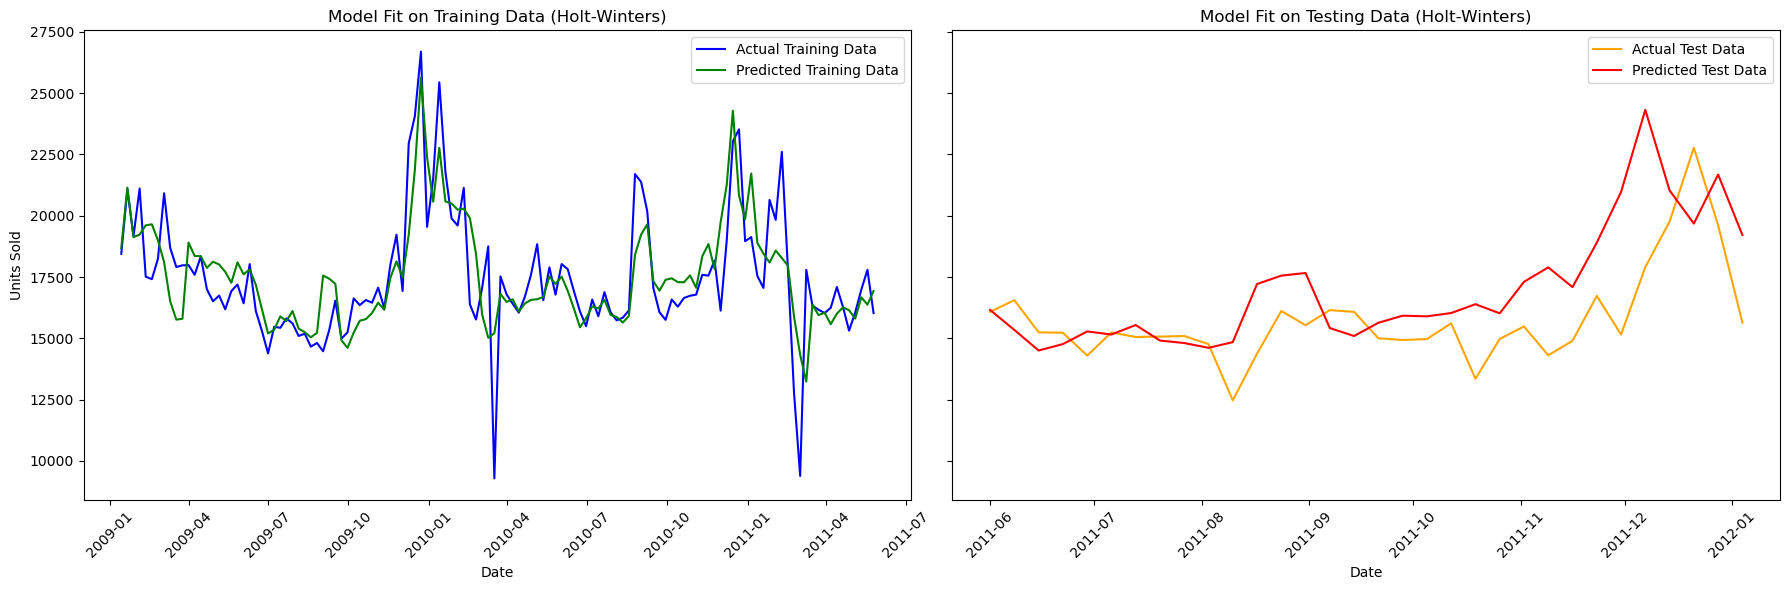

In [39]:
import matplotlib.pyplot as plt

# Prediction on training data
train_pred_add = hw_model_add.fittedvalues

# Prediction on testing data
test_pred_add = hw_model_add.forecast(steps=len(test))
# Plotting the results on separate subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot for training data
ax[0].plot(train.index, train, label='Actual Training Data', color='blue')
ax[0].plot(train.index, train_pred_add, label='Predicted Training Data', color='green')
ax[0].set_title('Model Fit on Training Data (Holt-Winters)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Units Sold')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

# Plot for testing data
ax[1].plot(test.index, test, label='Actual Test Data', color='orange')
ax[1].plot(test.index, test_pred_add, label='Predicted Test Data', color='red')
ax[1].set_title('Model Fit on Testing Data (Holt-Winters)')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<h1 style="color:black; font-size:30px;"><strong>Evaluation of Holt Winters</strong></h1>

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Calculate metrics for training
train_rmse_add = np.sqrt(mean_squared_error(train, train_pred_add))
train_mae_add = mean_absolute_error(train, train_pred_add)
train_mape_add = np.mean(np.abs((train - train_pred_add) / train)) * 100

# Calculate metrics for testing
test_rmse_add = np.sqrt(mean_squared_error(test, test_pred_add))
test_mae_add = mean_absolute_error(test, test_pred_add)
test_mape_add = np.mean(np.abs((test - test_pred_add) / test)) * 100

print("Training Data Evaluation Metrics:")
print(f"RMSE: {train_rmse_add}")
print(f"MAE: {train_mae_add}")
print(f"MAPE: {train_mape_add}%")

print("\nTesting Data Evaluation Metrics:")
print(f"RMSE: {test_rmse_add}")
print(f"MAE: {test_mae_add}")
print(f"MAPE: {test_mape_add}%")


Training Data Evaluation Metrics:
RMSE: 1651.782706985303
MAE: 1173.7501060357888
MAPE: 6.9655522276494715%

Testing Data Evaluation Metrics:
RMSE: 2284.602839200782
MAE: 1693.9490121327403
MAPE: 10.750576446450225%


<h1 style="color:black; font-size:30px;"><strong>Facebook Prophet Model</strong></h1>

In [41]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [42]:
from prophet import Prophet

df_prophet = pd.DataFrame({
    'ds': train.index,
    'y': train.values
})

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_prophet)

21:00:02 - cmdstanpy - INFO - Chain [1] start processing
21:00:02 - cmdstanpy - INFO - Chain [1] done processing


<h1 style="color:black; font-size:30px;"><strong>Prediction on Training Data</strong></h1>

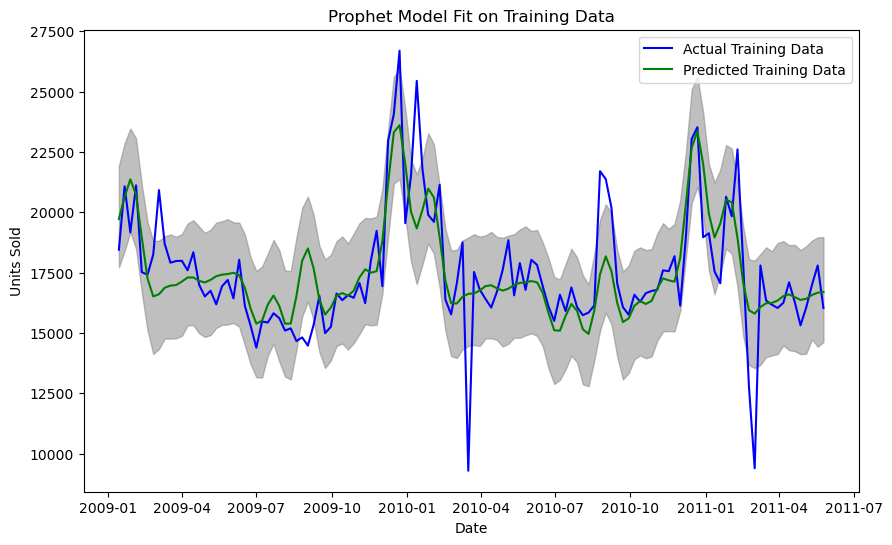

In [43]:
# Predict on the training data
train_forecast = model_prophet.predict(df_prophet)

# Plot the training data and its forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Actual Training Data', color='blue')
plt.plot(train_forecast['ds'], train_forecast['yhat'], label='Predicted Training Data', color='green')
plt.fill_between(train_forecast['ds'], train_forecast['yhat_lower'], train_forecast['yhat_upper'], color='gray', alpha=0.5)
plt.title('Prophet Model Fit on Training Data')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

<h1 style="color:black; font-size:30px;"><strong>Prediction on Testing Data</strong></h1>

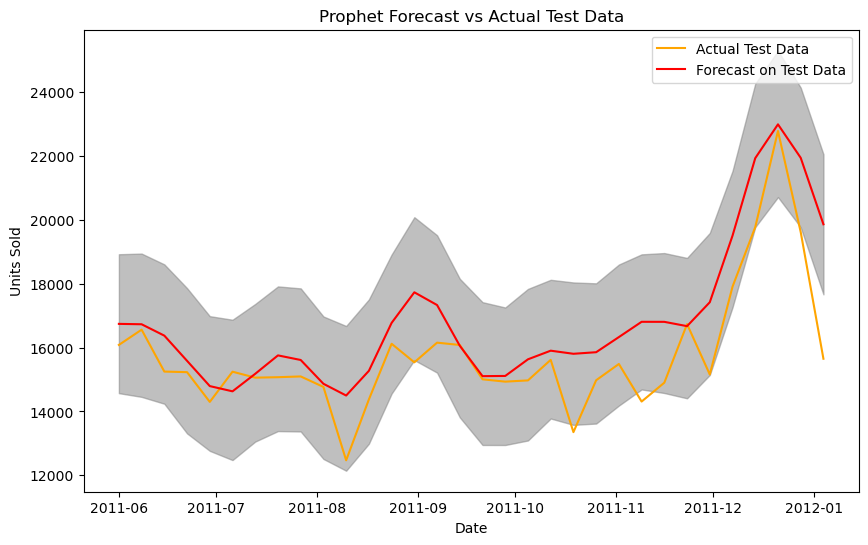

In [44]:
# Forecast on new data
test_forecast = model_prophet.predict(pd.DataFrame({'ds': test.index}))

# Plot the actual test data and its forecast
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast on Test Data', color='red')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='gray', alpha=0.5)
plt.title('Prophet Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

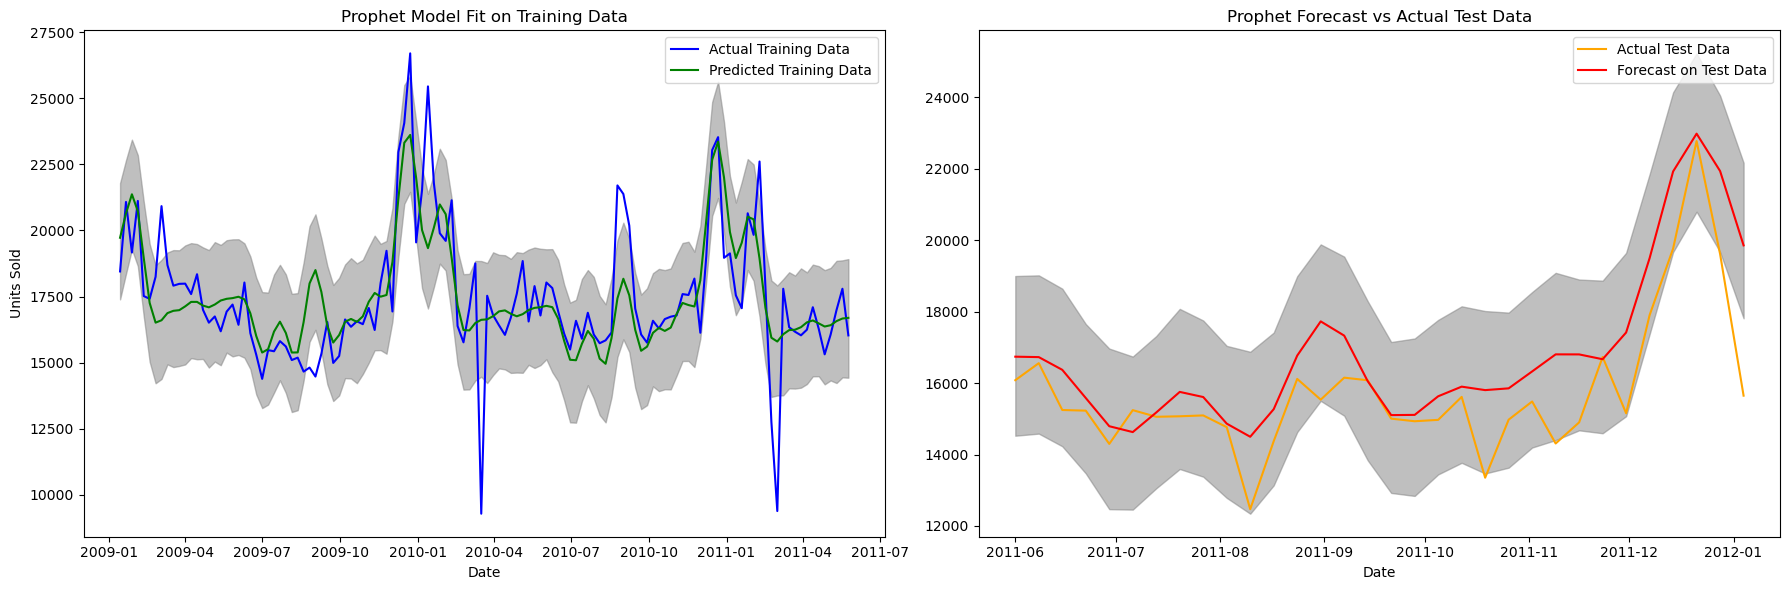

In [45]:
import matplotlib.pyplot as plt

# Predict on the training data
train_forecast = model_prophet.predict(df_prophet)

# Forecast on new data
test_forecast = model_prophet.predict(pd.DataFrame({'ds': test.index}))

# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot the training data and its forecast
ax[0].plot(train.index, train, label='Actual Training Data', color='blue')
ax[0].plot(train_forecast['ds'], train_forecast['yhat'], label='Predicted Training Data', color='green')
ax[0].fill_between(train_forecast['ds'], train_forecast['yhat_lower'], train_forecast['yhat_upper'], color='gray', alpha=0.5)
ax[0].set_title('Prophet Model Fit on Training Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Units Sold')
ax[0].legend()

# Plot the actual test data and its forecast
ax[1].plot(test.index, test, label='Actual Test Data', color='orange')
ax[1].plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast on Test Data', color='red')
ax[1].fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='gray', alpha=0.5)
ax[1].set_title('Prophet Forecast vs Actual Test Data')
ax[1].set_xlabel('Date')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<h1 style="color:black; font-size:30px;"><strong>Evaluation of FB Prophet</strong></h1>

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def safe_mape(y_true, y_pred):
    epsilon = np.finfo(float).eps 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Metrics for training data
train_rmse = np.sqrt(mean_squared_error(train.values, train_forecast['yhat'].values))
train_mae = mean_absolute_error(train.values, train_forecast['yhat'].values)
train_mape = safe_mape(train.values, train_forecast['yhat'].values)

print("Training Data Evaluation Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape}%")

# Metrics for testing data
test_rmse = np.sqrt(mean_squared_error(test.values, test_forecast['yhat'].values))
test_mae = mean_absolute_error(test.values, test_forecast['yhat'].values)
test_mape = safe_mape(test.values, test_forecast['yhat'].values)

print("\nTesting Data Evaluation Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"MAPE: {test_mape}%")


Training Data Evaluation Metrics:
RMSE: 1720.0668553751898
MAE: 1146.5426953009808
MAPE: 6.911668448252454%

Testing Data Evaluation Metrics:
RMSE: 1458.7186346059416
MAE: 1075.0973891173378
MAPE: 6.952813462254179%


In [47]:
# Calculate the average of the actual test data
average_sales = test.mean()

# Calculate RMSE and MAE as a percentage of the average sales
rmse_percentage = (test_rmse / average_sales) * 100
mae_percentage = (test_mae / average_sales) * 100

# Now, you can print these percentages to assess the error magnitude relative to the data scale

print(f'RMSE as a percentage of average sales: {rmse_percentage}%')
print(f'MAE as a percentage of average sales: {mae_percentage}%')

RMSE as a percentage of average sales: 9.25232478724748%
MAE as a percentage of average sales: 6.819101357899989%
